<a href="https://colab.research.google.com/github/Xabz/Activity-recognition/blob/main/Activity_Regocnition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import glob
import shutil
import random
import time
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras

from scipy import stats

from tensorflow.keras import backend as K
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings('ignore')

random.Random(12)
random.seed(12)

###Wisdm Raw_sensor data

In [ ]:
%%capture
!unzip '/content/drive/MyDrive/Dataset/wisdm-dataset.zip' -d /content/

In [ ]:
window_size = 128
overlap_size = int(window_size * 0.5)

segmented_data = np.zeros((45375, window_size, 6))
labels = []

accel_files = sorted(glob.glob('/content/wisdm-dataset/raw/phone/accel/*.txt'))
gyro_files = sorted(glob.glob('/content/wisdm-dataset/raw/phone/gyro/*.txt'))

accel_columns = ['Subject_id', 'Activity_Label_acc', 'Timestamp', 'Acc_x', 'Acc_y', 'Acc_z']
gyro_columns = ['Subject_id', 'Activity_Label_gyro', 'Timestamp', 'Gyro_x', 'Gyro_y', 'Gyro_z']
print(len(accel_files),len(gyro_files))

initial=0

for accel, gyro in zip(accel_files,gyro_files):
    accel_df = pd.read_csv(accel,sep=',',names=accel_columns)
    accel_df['Acc_z'] = accel_df['Acc_z'].str.replace(';','').apply(lambda x:float(x))
    gyro_df = pd.read_csv(gyro,sep=',',names=gyro_columns)
    gyro_df['Gyro_z'] = gyro_df['Gyro_z'].str.replace(';','').apply(lambda x:float(x))

    merged_df = pd.merge(accel_df,gyro_df,on='Timestamp')
    merged_df = merged_df.loc[:, ['Acc_x', 'Acc_y', 'Acc_z','Gyro_x', 'Gyro_y', 'Gyro_z','Activity_Label_acc']]


    data = merged_df.values

    num_windows = int(np.ceil((data.shape[0] - window_size) / overlap_size))

    # Segment the data using a sliding window approach
    for i in range(num_windows):
        start = i * overlap_size
        end = start + window_size
        segmented_data[initial] = data[start:end,:-1]
        labels.append(stats.mode(data[start:end,-1])[0][0])
        initial+=1
    

labels = LabelEncoder().fit_transform(labels)
labels = OneHotEncoder(sparse=False).fit_transform(labels.reshape(-1,1))

print(segmented_data.shape,labels.shape)
X_train = segmented_data[:36300,...]
y_train = labels[:36300,...]
x_test = segmented_data[36300:,...]
y_test = labels[36300:,...]

print(X_train.shape,y_train.shape,x_test.shape,y_test.shape)

51 51
(45375, 128, 6) (45375, 18)
(36300, 128, 6) (36300, 18) (9075, 128, 6) (9075, 18)


### UCI_HAR raw_sensor data

In [ ]:
%%capture
!unzip '/content/drive/MyDrive/Dataset/UCI HAR Dataset.zip' -d /content/

In [ ]:
files_path = sorted(glob.glob('/content/UCI HAR Dataset/train/Inertial Signals/*.txt'))
label_path = '/content/UCI HAR Dataset/train/y_train.txt'

X_train = np.zeros((7352,128,9))

for index,file_name in enumerate(files_path):
    column_name = file_name.split('/')[-1].split('.')[0]
    df = pd.read_csv(file_name,sep='\t', header=None,names=[column_name])
    df[column_name] = df[column_name].apply(lambda x: [float(i) for i in x.split()])

    for ind, row in df.iterrows():
        X_train[ind,:,index] = row[0]
        
label_df = pd.read_csv(label_path,header=None,names=['label'])
label_df['label'] = label_df['label'].apply(lambda x: int(x))
y_train = np.asarray(label_df).squeeze()
y_train = LabelEncoder().fit_transform(y_train)
y_train = OneHotEncoder(sparse=False).fit_transform(y_train.reshape(-1,1))

print(X_train.shape,y_train.shape)

(7352, 128, 9) (7352, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
files_path = sorted(glob.glob('/content/UCI HAR Dataset/test/Inertial Signals/*.txt'))
label_path = '/content/UCI HAR Dataset/test/y_test.txt'

x_test = np.zeros((2947,128,9))

for index,file_name in enumerate(files_path):
    column_name = file_name.split('/')[-1].split('.')[0]
    df = pd.read_csv(file_name,sep='\t', header=None,names=[column_name])
    df[column_name] = df[column_name].apply(lambda x: [float(i) for i in x.split()])

    for ind, row in df.iterrows():
        x_test[ind,:,index] = row[0]
        
label_df = pd.read_csv(label_path,header=None,names=['label'])
label_df['label'] = label_df['label'].apply(lambda x: int(x))
y_test = np.asarray(label_df).squeeze()
y_test = LabelEncoder().fit_transform(y_test)
y_test = OneHotEncoder(sparse=False).fit_transform(y_test.reshape(-1,1))
print(x_test.shape,y_test.shape)

(2947, 128, 9) (2947, 6)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


##DataGenerator


In [ ]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self,X,y,batch_size,input_shape,p=None):
        self.X = X                    #input data
        self.y = y                    #input labels
        self.batch_size = batch_size
        self.input_shape = input_shape
        self.total       = len(X)        

        self.indexes     = np.arange(self.total)
        self.total_batch = self.total // self.batch_size 
        self.classes = len(np.unique(self.y))
        # self.p = p
        self.rand = random.Random(12)
        random.seed(12)

    def on_epoch_end(self):
        np.random.shuffle(self.indexes)


    def __len__(self):
        return int(self.total // self.batch_size)


    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
            
        return self.X[indexes], [self.y[indexes],self.y[indexes]]
        # return self.X[indexes], self.y[indexes]
        

        

##Callback

In [ ]:
from sklearn.metrics import classification_report
class MyLogger(tf.keras.callbacks.Callback):
    def __init__(self, n=None, validation_data=None,AE=None):
        sel
        f.n = n   # print loss & acc every n epochs
        if validation_data != None:
            self.x_val, self.y_val = validation_data
        self.start_time = time.time()
        self.start_epoch = 0
        self.AE = AE

            
        

    def on_epoch_end(self, epoch, logs={}):
        
        self.start_epoch +=1
        if self.start_epoch % self.n != 0 and self.start_epoch != 1: return

        self.start_time = time.time()
        
        cm = self._evaluate(self.y_val)

        ep_time = time.time() - self.start_time
        print(f"\rEpoch {self.start_epoch}: Time:{ep_time:.1f}",
              end='\n')
        print(f" {cm} ",end='\n')
        



    def _evaluate(self,y_val):
        outs = self.AE.predict(self.x_val)
        cm = tf.math.confusion_matrix(np.argmax(y_val,axis=1), np.argmax(outs,axis=1)) 
      
        return cm

##ResNet type CNN and BI-LSTM

In [ ]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  #kernel_regularizer=tf.keras.regularizers.l2(0.001)
  
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  #second block # bottleneck (but size kept same with padding)
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same', )(x)
  x = tf.keras.layers.BatchNormalization()(x)

  # third block activation used after adding the input
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  
  # x = Activation(activations.relu)(x)

  # add the input 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x


def conv_skip(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  # when s = 2 then it is like downsizing the feature map
  x = tf.keras.layers.BatchNormalization()(x)
  

  # second block
  # x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  #third block
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.MaxPooling1D(pool_size=3,strides=2)(x)
  x = tf.keras.layers.ZeroPadding1D(padding=(0,1))(x)

  # shortcut 
  x_skip = tf.keras.layers.Conv1D(f1, kernel_size=1, strides=2, padding='valid')(x_skip)
  x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x


def maxpool_skip(x, filters):
  '''
  here the input size changes''' 
 

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters
  
  #first block 
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)

  #second block # bottleneck (but size kept same with padding)
  
  
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  # x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)

  # third block activation used after adding the input
  
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same', )(x)
  x = tf.keras.layers.BatchNormalization()(x)
  
  x = tf.keras.layers.MaxPooling1D(pool_size = 3,strides=2)(x)
  x = tf.keras.layers.ZeroPadding1D(padding=(0,1))(x)

  # shortcut 
  x_skip = tf.keras.layers.Conv1D(f1, kernel_size=1, strides=2, padding='valid')(x_skip)
  x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add 
  x = tf.keras.layers.Add()([x, x_skip])
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x

def buildAE(input_shape,classes,learning_rate):

    input = tf.keras.Input(shape=input_shape)
    # x = tf.keras.layers.ZeroPadding1D(padding=(2,2))(input)
    x = tf.keras.layers.Conv1D(16, kernel_size=3, strides=1,padding='same',)(input)

    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(x)
    


    x = conv_skip(x ,filters=(16,16))
    for i in range(3):
        x = res_identity(x,filters=(16,16))
    x = maxpool_skip(x,filters=(16,16))


    # class_name = ['non-fall','pre-fall','fall']

    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16,activation='tanh',return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32,activation='tanh'))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(units=64)(x)
    x = tf.keras.layers.Dense(units=classes)(x)
        # ens.append(res)

    # x = tf.keras.layers.Concatenate()(ens)
    output = tf.keras.layers.Activation('softmax')(x)
    model = tf.keras.Model(input,output)

    # model = tf.keras.Model(input,ens)

    # loss_weights = {
    # 'non-fall': class_weights[0],  # no weighting
    # 'pre-fall': class_weights[1],  # double weight
    # 'fall': class_weights[2]   # half weight
    # }


    
    print('Params', model.count_params())
    model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


    model.summary()
    
    return model
# model = buildAE((256,6),3,0.0005)
# tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
batch_size = 64
learning_rate = 0.001
def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
     return lr * tf.math.exp(-0.01)

dg = DataGenerator(X_train,y_train,batch_size=batch_size,input_shape=X_train.shape[1:])
model = buildAE(X_train.shape[1:],y_train.shape[-1],learning_rate)
log = MyLogger(n=1, validation_data=(x_test,y_test), AE=model)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)


# history = model.fit(dg, epochs=101, verbose=1,callbacks = [lr_scheduler], validation_data=(x_test,y_test))




Params 38854
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 128, 16)      448         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 16)     64          ['conv1d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 128, 16)      0           ['batch_normaliz

93/93 [==============================] - 10s 11ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       496
           1       0.99      0.97      0.98       471
           2       0.93      0.98      0.96       420
           3       0.96      0.89      0.92       491
           4       0.91      0.96      0.94       532
           5       0.99      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



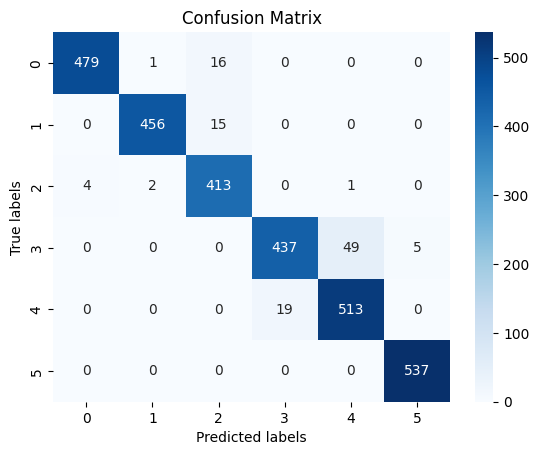

<Figure size 640x480 with 0 Axes>

In [ ]:

model = tf.keras.models.load_model('/content/resnet.h5')
outs = model.predict(x_test)

class_names= np.unique(np.argmax(y_test,axis=1))


cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(outs,axis=1))

print(classification_report(np.argmax(y_test,axis=1), np.argmax(outs,axis=1)))


sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# set the axis labels and title of the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show()
plt.savefig('confusion_matrix.png')


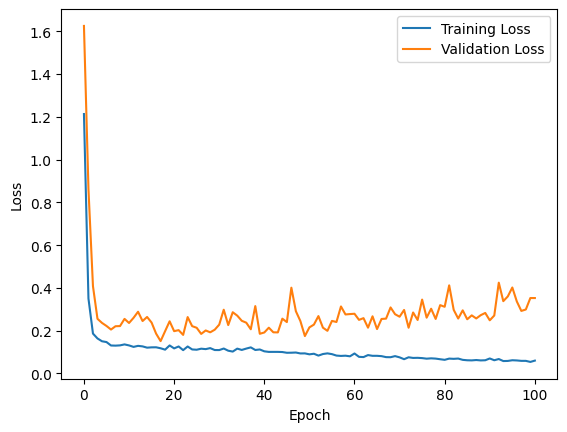

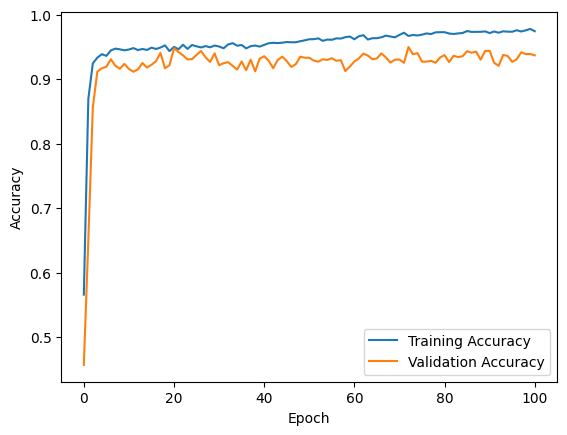

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## resnet like multi-filters module

In [ ]:
def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  #kernel_regularizer=tf.keras.regularizers.l2(0.001)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=1, strides=1, padding='same')(x)
  

  #second block # bottleneck (but size kept same with padding)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same', )(x)
  

  # third block activation used after adding the input
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=1, strides=1, padding='same')(x)

  # add the input 
  x = tf.keras.layers.Add()([x, x_skip])
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  return x

def conv_skip(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=2, padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  # x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(x)
  

  # second block
  x = tf.keras.layers.Conv1D(f2, kernel_size=1, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #third block
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  

  # shortcut 
  x_skip = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=2, padding='valid')(x_skip)
  # x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x

def multi_fiter_conv(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x1 = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Activation(tf.keras.activations.relu)(x1)
  

  # second block
  x2 = tf.keras.layers.Conv1D(f1, kernel_size=5, strides=1, padding='same')(x)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.Activation(tf.keras.activations.relu)(x2)

  #third block
  x3 = tf.keras.layers.Conv1D(f1, kernel_size=7, strides=1, padding='same')(x)
  x3 = tf.keras.layers.BatchNormalization()(x3)
  x3 = tf.keras.layers.Activation(tf.keras.activations.relu)(x3)


  # # forth block
  # x4 = tf.keras.layers.Conv1D(f1, kernel_size=9, strides=1, padding='same')(x)
  # x4 = tf.keras.layers.BatchNormalization()(x4)
  # x4 = tf.keras.layers.Activation(tf.keras.activations.relu)(x4)

  # concatenate 
  x = tf.keras.layers.Concatenate()([x1,x2,x3])
  x = tf.keras.layers.Conv1D(f1,kernel_size=3,strides=1,padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #add
  x = tf.keras.layers.Add()([x,x_skip])

  return x



def buildAE(input_shape,classes,learning_rate):

    input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(input)
    x = tf.keras.layers.Conv1D(16, kernel_size=3, strides=1,padding='valid',)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(x)

    x = multi_fiter_conv(x,filters=(16,16))

    x = conv_skip(x ,filters=(16,32))
    # print(x.shape)
    x = res_identity(x,filters=(16,32))
    x = multi_fiter_conv(x,filters=(16,16))
    x = conv_skip(x ,filters=(16,32))
    x = res_identity(x,filters=(16,32))
    x = res_identity(x,filters=(16,32))
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
    # x = maxpool_skip(x,filters=(16,16))





    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16,activation='tanh',return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32,activation='tanh'))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(units=64)(x)
    x = tf.keras.layers.Dense(units=classes)(x)
    output = tf.keras.layers.Activation('softmax')(x)


    model = tf.keras.Model(input,output)


    
    print('Params', model.count_params())
    model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),],
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


    # model.summary()
    
    return model
model = buildAE((128,9),6,0.0005)
# tf.keras.utils.plot_model(model,show_shapes=True)

In [ ]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]
batch_size = 64
learning_rate = 0.001
print(X_train.shape,y_train.shape)

def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
     return lr * tf.math.exp(-0.01)

dg = DataGenerator(X_train,y_train,batch_size=batch_size,input_shape=X_train.shape[1:])
model = buildAE(X_train.shape[1:],y_train.shape[-1],learning_rate)
log = MyLogger(n=1, validation_data=(x_test,y_test), AE=model)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(dg, epochs=101, verbose=1,callbacks = [lr_scheduler], validation_data=(x_test,y_test))

(7352, 128, 9) (7352, 6)
Params 54886
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 zero_padding1d_3 (ZeroPadding1  (None, 130, 9)      0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_43 (Conv1D)             (None, 128, 16)      448         ['zero_padding1d_3[0][0]']       
                                                                                                  
 batch_normalization_44 (BatchN  (None, 128, 16)     6

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['categorical_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_categorical_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

93/93 [==============================] - 3s 10ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       496
           1       0.97      0.98      0.97       471
           2       0.98      1.00      0.99       420
           3       0.93      0.87      0.90       491
           4       0.89      0.97      0.93       532
           5       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



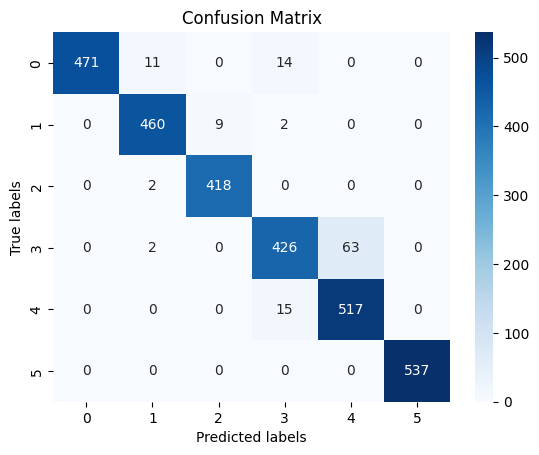

<Figure size 640x480 with 0 Axes>

In [ ]:

model = tf.keras.models.load_model('/content/resnet_inception_v2_my_model.h5')
outs = model.predict(x_test)

class_names= np.unique(np.argmax(y_test,axis=1))


cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(outs,axis=1))

print(classification_report(np.argmax(y_test,axis=1), np.argmax(outs,axis=1)))


sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# set the axis labels and title of the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show()
plt.savefig('confusion_matrix.png')


## new rcjtecture with 96.76

In [ ]:

def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  #kernel_regularizer=tf.keras.regularizers.l2(0.001)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  

  #second block # bottleneck (but size kept same with padding)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same', )(x)
  

  # third block activation used after adding the input
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same')(x)

  # add the input 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  return x

def conv_skip(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=2, padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  # x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(x)
  

  # second block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #third block
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  

  # shortcut 
  x_skip = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=2, padding='valid')(x_skip)
  # x_skip = tf.keras.layers.MaxPool1D(pool_size=3,strides=2)(x_skip)
  # x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x

def multi_fiter_conv(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x1 = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Activation(tf.keras.activations.relu)(x1)
  

  # second block
  x2 = tf.keras.layers.Conv1D(f1, kernel_size=5, strides=1, padding='same')(x)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.Activation(tf.keras.activations.relu)(x2)

  #third block
  x3 = tf.keras.layers.Conv1D(f1, kernel_size=7, strides=1, padding='same')(x)
  x3 = tf.keras.layers.BatchNormalization()(x3)
  x3 = tf.keras.layers.Activation(tf.keras.activations.relu)(x3)


  # # forth block
  # x4 = tf.keras.layers.Conv1D(f1, kernel_size=9, strides=1, padding='same')(x)
  # x4 = tf.keras.layers.BatchNormalization()(x4)
  # x4 = tf.keras.layers.Activation(tf.keras.activations.relu)(x4)

  # concatenate 
  x = tf.keras.layers.Concatenate()([x1,x2,x3])
  x = tf.keras.layers.Conv1D(f2,kernel_size=3,strides=1,padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #add
  x = tf.keras.layers.Add()([x,x_skip])

  return x


def buildAE(input_shape,classes,learning_rate):

    input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(input)
    x = tf.keras.layers.Conv1D(16, kernel_size=3, strides=1,padding='valid',)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(x)

    x = multi_fiter_conv(x,filters=(16,16))

    x = conv_skip(x ,filters=(16,32))
    # print(x.shape)
    x = res_identity(x,filters=(16,32))
    x = multi_fiter_conv(x,filters=(32,32))
    x = conv_skip(x ,filters=(32,64))
    x = res_identity(x,filters=(32,64))
    x = res_identity(x,filters=(32,64))
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
    # x = maxpool_skip(x,filters=(16,16))

    output_opt = tf.keras.layers.Flatten()(x)
    output_opt = tf.keras.layers.Dense(units=64)(output_opt)
    output_opt = tf.keras.layers.Dense(units=classes)(output_opt)
    output_opt = tf.keras.layers.Activation('softmax')(output_opt)



    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16,activation='tanh',return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32,activation='tanh'))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Dense(units=64)(x)
    x = tf.keras.layers.Dense(units=classes)(x)
    output = tf.keras.layers.Activation('softmax')(x)


    # model = tf.keras.Model(input,output)

    pred_model = tf.keras.Model(input,output)
    model = tf.keras.Model(input,[output,output_opt])


    
    print('Params', model.count_params())
    model.compile(loss = [tf.keras.losses.CategoricalCrossentropy(),
                          tf.keras.losses.CategoricalCrossentropy()],
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


    model.summary()
    
    return model, pred_model
model = buildAE((128,9),6,0.0005)
# tf.keras.utils.plot_model(model,show_shapes=True)

Params 186156
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 130, 9)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 16)      448         ['zero_padding1d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 16)     64          ['conv1d[0][0]']                 
 alization)                                                                   

In [ ]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]
batch_size = 64
learning_rate = 0.001
print(X_train.shape,y_train.shape)


def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
     return lr * tf.math.exp(-0.01)

dg = DataGenerator(X_train,y_train,batch_size=batch_size,input_shape=X_train.shape[1:])
model,pred_model = buildAE(X_train.shape[1:],y_train.shape[-1],learning_rate)
# log = MyLogger(n=1, validation_data=(x_test,y_test), AE=model)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

print('Params', model.count_params())

history = model.fit(dg, epochs=251, verbose=1,callbacks = [lr_scheduler], validation_data=(x_test,y_test))

(7352, 128, 9) (7352, 6)
Params 186156
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 130, 9)      0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 128, 16)      448         ['zero_padding1d_1[0][0]']       
                                                                                                  
 batch_normalization_25 (BatchN  (None, 128, 16)     

93/93 [==============================] - 4s 10ms/step
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       496
           1       0.99      0.97      0.98       471
           2       0.96      1.00      0.98       420
           3       0.91      0.94      0.92       491
           4       0.97      0.95      0.96       532
           5       0.98      1.00      0.99       537

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



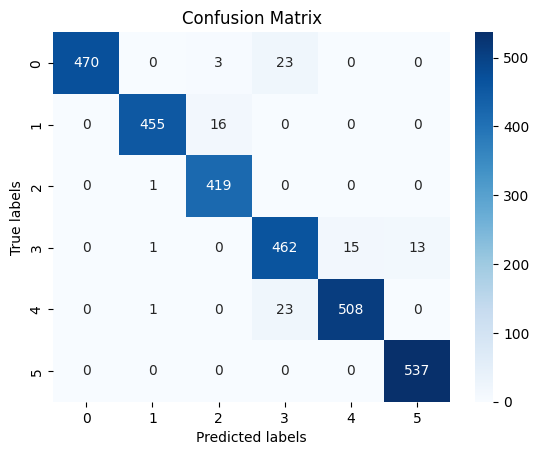

<Figure size 640x480 with 0 Axes>

In [ ]:

model = tf.keras.models.load_model('/content/Adaptive_multifilter_CNN_Bi-LSTM.h5')
outs = model.predict(x_test)


class_names= np.unique(np.argmax(y_test,axis=1))


cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(outs[0],axis=1))

print(classification_report(np.argmax(y_test,axis=1), np.argmax(outs[0],axis=1)))


sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# set the axis labels and title of the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show()
plt.savefig('confusion_matrix.png')


##Multikernel_ResNetV2_BI-LSTM

In [ ]:

def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  x = tf.keras.layers.Conv1D(f1, kernel_size=1, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  
  

  #second block # bottleneck (but size kept same with padding)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same', )(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  
  

  # third block activation used after adding the input
  x = tf.keras.layers.Conv1D(f2, kernel_size=1, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  

  # add the input 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  return x

def conv_skip(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = tf.keras.layers.Conv1D(f1, kernel_size=1, strides=1, padding='same')(x)
  # when s = 2 then it is like downsizing the feature map
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  # x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(x)
  

  # second block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=2, padding='valid')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #third block
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  

  # shortcut 
  x_skip = tf.keras.layers.Conv1D(f2, kernel_size=1, strides=1, padding='same')(x_skip)
  x_skip = tf.keras.layers.MaxPool1D(pool_size=3,strides=2)(x_skip)
  # x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add 
  x = tf.keras.layers.Add()([x, x_skip])
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  return x

def multi_fiter_conv(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x1 = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Activation(tf.keras.activations.relu)(x1)
  

  # second block
  x2 = tf.keras.layers.Conv1D(f1, kernel_size=5, strides=1, padding='same')(x)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.Activation(tf.keras.activations.relu)(x2)

  #third block
  x3 = tf.keras.layers.Conv1D(f1, kernel_size=7, strides=1, padding='same')(x)
  x3 = tf.keras.layers.BatchNormalization()(x3)
  x3 = tf.keras.layers.Activation(tf.keras.activations.relu)(x3)


  # forth block
  x4 = tf.keras.layers.Conv1D(f1, kernel_size=9, strides=1, padding='same')(x)
  x4 = tf.keras.layers.BatchNormalization()(x4)
  x4 = tf.keras.layers.Activation(tf.keras.activations.relu)(x4)

  # concatenate 
  x = tf.keras.layers.Concatenate()([x1,x2,x3,x4])
  # x = tf.keras.layers.Conv1D(f2,kernel_size=3,strides=1,padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  # x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  # #add
  # x = tf.keras.layers.Add()([x,x_skip])

  return x


def buildAE(input_shape,classes,learning_rate):

    input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(input)
    x = tf.keras.layers.Conv1D(16, kernel_size=3, strides=1,padding='valid',)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(x)

    x = multi_fiter_conv(x,filters=(16,16))

    x = conv_skip(x ,filters=(16,32))
    # print(x.shape)
    x = res_identity(x,filters=(16,32))
    x = multi_fiter_conv(x,filters=(32,32))
    x = conv_skip(x ,filters=(32,64))
    x = res_identity(x,filters=(32,64))
    x = res_identity(x,filters=(32,64))
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
    # x = maxpool_skip(x,filters=(16,16))

    output_opt = tf.keras.layers.Flatten()(x)
    # output_opt = tf.keras.layers.Dense(units=64)(output_opt)
    output_opt = tf.keras.layers.Dense(units=classes)(output_opt)
    output_opt = tf.keras.layers.Activation('softmax')(output_opt)



    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16,activation='tanh',return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32,activation='tanh'))(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # x = tf.keras.layers.Dense(units=64)(x)
    x = tf.keras.layers.Dense(units=classes)(x)
    output = tf.keras.layers.Activation('softmax')(x)


    # model = tf.keras.Model(input,output)

    pred_model = tf.keras.Model(input,output)
    model = tf.keras.Model(input,[output,output_opt])


    
    print('Params', model.count_params())
    model.compile(loss = [tf.keras.losses.CategoricalCrossentropy(),
                          tf.keras.losses.CategoricalCrossentropy()],
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


    model.summary()
    
    return model
model = buildAE((128,9),6,0.0005)
# tf.keras.utils.plot_model(model,show_shapes=True)

Params 111660
Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_18 (InputLayer)          [(None, 128, 9)]     0           []                               
                                                                                                  
 zero_padding1d_16 (ZeroPadding  (None, 130, 9)      0           ['input_18[0][0]']               
 1D)                                                                                              
                                                                                                  
 conv1d_387 (Conv1D)            (None, 128, 16)      448         ['zero_padding1d_16[0][0]']      
                                                                                                  
 batch_normalization_382 (Batch  (None, 128, 16)     64          ['conv1d_387

In [ ]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]
batch_size = 64
learning_rate = 0.001
print(X_train.shape,y_train.shape)


def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
     return lr * tf.math.exp(-0.01)

dg = DataGenerator(X_train,y_train,batch_size=batch_size,input_shape=X_train.shape[1:])
model = buildAE(X_train.shape[1:],y_train.shape[-1],learning_rate)
# log = MyLogger(n=1, validation_data=(x_test,y_test), AE=model)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

print('Params', model.count_params())

history = model.fit(dg, epochs=101, verbose=1,callbacks = [lr_scheduler], validation_data=(x_test,y_test))

(7352, 128, 9) (7352, 6)
Params 111660
Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_19 (InputLayer)          [(None, 128, 9)]     0           []                               
                                                                                                  
 zero_padding1d_17 (ZeroPadding  (None, 130, 9)      0           ['input_19[0][0]']               
 1D)                                                                                              
                                                                                                  
 conv1d_413 (Conv1D)            (None, 128, 16)      448         ['zero_padding1d_17[0][0]']      
                                                                                                  
 batch_normalization_409 (Batch  (None, 128, 16)    

93/93 [==============================] - 3s 8ms/step
              precision    recall  f1-score   support

           0       0.96      0.97      0.96       496
           1       0.98      0.96      0.97       471
           2       0.97      0.99      0.98       420
           3       0.97      0.86      0.91       491
           4       0.88      0.98      0.93       532
           5       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



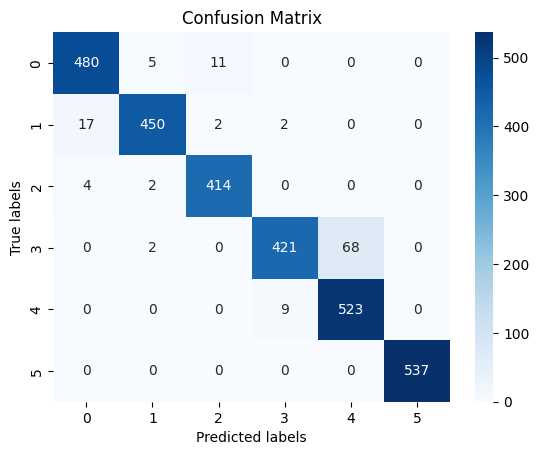

<Figure size 640x480 with 0 Axes>

In [ ]:
model.save('Adaptive_Multikernel_ResNetV2_BI-LSTM.h5')

model = tf.keras.models.load_model('/content/Adaptive_Multikernel_ResNetV2_BI-LSTM.h5')
outs = model.predict(x_test)


class_names= np.unique(np.argmax(y_test,axis=1))


cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(outs[0],axis=1))

print(classification_report(np.argmax(y_test,axis=1), np.argmax(outs[0],axis=1)))


sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# set the axis labels and title of the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show()
plt.savefig('confusion_matrix.png')


##Multifilter_resnet_Bi-LSTM_self_attention 97.26

In [ ]:

def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  #kernel_regularizer=tf.keras.regularizers.l2(0.001)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  

  #second block # bottleneck (but size kept same with padding)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same', )(x)
  

  # third block activation used after adding the input
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same')(x)

  # add the input 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  return x

def conv_skip(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=2, padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  # x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(x)
  

  # second block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #third block
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  

  # shortcut 
  x_skip = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=2, padding='valid')(x_skip)
  # x_skip = tf.keras.layers.MaxPool1D(pool_size=3,strides=2)(x_skip)
  # x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x

def multi_fiter_conv(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x1 = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Activation(tf.keras.activations.relu)(x1)
  

  # second block
  x2 = tf.keras.layers.Conv1D(f1, kernel_size=5, strides=1, padding='same')(x)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.Activation(tf.keras.activations.relu)(x2)

  #third block
  x3 = tf.keras.layers.Conv1D(f1, kernel_size=7, strides=1, padding='same')(x)
  x3 = tf.keras.layers.BatchNormalization()(x3)
  x3 = tf.keras.layers.Activation(tf.keras.activations.relu)(x3)


  # # forth block
  # x4 = tf.keras.layers.Conv1D(f1, kernel_size=9, strides=1, padding='same')(x)
  # x4 = tf.keras.layers.BatchNormalization()(x4)
  # x4 = tf.keras.layers.Activation(tf.keras.activations.relu)(x4)

  # concatenate 
  x = tf.keras.layers.Concatenate()([x1,x2,x3])
  x = tf.keras.layers.Conv1D(f2,kernel_size=3,strides=1,padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #add
  x = tf.keras.layers.Add()([x,x_skip])

  return x



class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_units):
        super(SelfAttention, self).__init__()
        self.num_units = num_units
        self.WQ = tf.keras.layers.Dense(units=num_units)
        self.WK = tf.keras.layers.Dense(units=num_units)
        self.WV = tf.keras.layers.Dense(units=num_units)
        self.softmax = tf.keras.layers.Softmax()

    def call(self, inputs):
        Q = self.WQ(inputs)
        K = self.WK(inputs)
        V = self.WV(inputs)
        attention_logits = tf.matmul(Q, K, transpose_b=True)
        attention_weights = self.softmax(attention_logits)
        attention_output = tf.matmul(attention_weights, V)
        return attention_output

def buildAE(input_shape,classes,learning_rate):

    input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(input)
    x = tf.keras.layers.Conv1D(16, kernel_size=3, strides=1,padding='valid',)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(x)

    x = multi_fiter_conv(x,filters=(16,16))

    x = conv_skip(x ,filters=(16,32))
    # print(x.shape)
    x = res_identity(x,filters=(16,32))
    x = multi_fiter_conv(x,filters=(32,32))
    x = conv_skip(x ,filters=(32,64))
    x = res_identity(x,filters=(32,64))
    x = res_identity(x,filters=(32,64))
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
    # x = maxpool_skip(x,filters=(16,16))
    
    # output_opt = SelfAttention(32)(x)
    output_opt = tf.keras.layers.Flatten()(x)
    # output_opt = tf.keras.layers.Dense(units=64)(output_opt)
    output_opt = tf.keras.layers.Dense(units=classes)(output_opt)
    output_opt = tf.keras.layers.Activation('softmax',name='Opt_Output')(output_opt)



    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16,activation='tanh',return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = SelfAttention(num_units=32)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32,activation='tanh',return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = SelfAttention(num_units=64)(x)
    x = tf.keras.layers.Flatten()(x)
    

    # x = tf.keras.layers.Dense(units=64)(x)
    x = tf.keras.layers.Dense(units=classes)(x)
    output = tf.keras.layers.Activation('softmax',name='Output')(x)


    # model = tf.keras.Model(input,output)

    pred_model = tf.keras.Model(input,output)
    model = tf.keras.Model(input,[output,output_opt])


    
    print('Params', model.count_params())
    model.compile(loss = [tf.keras.losses.CategoricalCrossentropy(),
                          tf.keras.losses.CategoricalCrossentropy()],
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


    model.summary()
    
    return model, pred_model
model = buildAE((128,9),6,0.0005)
# tf.keras.utils.plot_model(model,show_shapes=True)

Params 146892
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 zero_padding1d (ZeroPadding1D)  (None, 130, 9)      0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 128, 16)      448         ['zero_padding1d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 16)     64          ['conv1d[0][0]']                 
 alization)                                                                   

In [ ]:
input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]
batch_size = 64
learning_rate = 0.001
print(X_train.shape,y_train.shape)

def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
     return lr * tf.math.exp(-0.01)

dg = DataGenerator(X_train,y_train,batch_size=batch_size,input_shape=X_train.shape[1:])
model,pred_model = buildAE(X_train.shape[1:],y_train.shape[-1],learning_rate)
# log = MyLogger(n=1, validation_data=(x_test,y_test), AE=model)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(dg, epochs=251, verbose=1,callbacks = [lr_scheduler], validation_data=(x_test,y_test))

(36300, 128, 6) (36300, 18)
Params 169812
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 6)]     0           []                               
                                                                                                  
 zero_padding1d_1 (ZeroPadding1  (None, 130, 6)      0           ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_26 (Conv1D)             (None, 128, 16)      304         ['zero_padding1d_1[0][0]']       
                                                                                                  
 batch_normalization_25 (BatchN  (None, 128, 16)  

93/93 [==============================] - 5s 23ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.97       496
           1       0.99      0.96      0.98       471
           2       0.98      1.00      0.99       420
           3       0.94      0.93      0.94       491
           4       0.95      0.98      0.97       532
           5       0.99      1.00      0.99       537

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



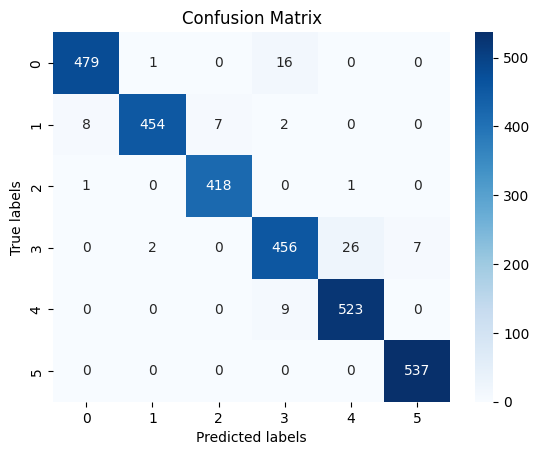

<Figure size 640x480 with 0 Axes>

In [ ]:
model.save('Adaptive_Multikernel_ResNetV2_BI-LSTM_Attention.h5')

# model = load_model('/content/Adaptive_Multikernel_ResNetV2_BI-LSTM_Attention.h5', custom_objects={'AttentionLayer': AttentionLayer})

model = tf.keras.models.load_model('/content/Adaptive_Multikernel_ResNetV2_BI-LSTM_Attention.h5',
                                   custom_objects= {'SelfAttention':SelfAttention})
outs = model.predict(x_test)


class_names= np.unique(np.argmax(y_test,axis=1))


cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(outs[0],axis=1))

print(classification_report(np.argmax(y_test,axis=1), np.argmax(outs[0],axis=1)))


sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# set the axis labels and title of the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show()
plt.savefig('confusion_matrix.png')


##extra

In [ ]:

def res_identity(x, filters): 
  #renet block where dimension doesnot change.
  #The skip connection is just simple identity conncection
  #we will have 3 blocks and then input will be added

  x_skip = x # this will be used for addition with the residual block 
  f1, f2 = filters

  #first block 
  #kernel_regularizer=tf.keras.regularizers.l2(0.001)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  

  #second block # bottleneck (but size kept same with padding)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same', )(x)
  

  # third block activation used after adding the input
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same')(x)

  # add the input 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  return x

def conv_skip(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=2, padding='valid')(x)
  # when s = 2 then it is like downsizing the feature map
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  # x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(x)
  

  # second block
  x = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #third block
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
  x = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=1, padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  

  # shortcut 
  x_skip = tf.keras.layers.Conv1D(f2, kernel_size=3, strides=2, padding='valid')(x_skip)
  # x_skip = tf.keras.layers.MaxPool1D(pool_size=3,strides=2)(x_skip)
  # x_skip = tf.keras.layers.BatchNormalization()(x_skip)

  # add 
  x = tf.keras.layers.Add()([x, x_skip])
  # x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)

  return x

def multi_fiter_conv(x, filters):
  '''
  here the input size changes''' 
  x_skip = x
  f1, f2 = filters

  # first block
  x1 = tf.keras.layers.Conv1D(f1, kernel_size=3, strides=1, padding='same')(x)
  x1 = tf.keras.layers.BatchNormalization()(x1)
  x1 = tf.keras.layers.Activation(tf.keras.activations.relu)(x1)
  

  # second block
  x2 = tf.keras.layers.Conv1D(f1, kernel_size=5, strides=1, padding='same')(x)
  x2 = tf.keras.layers.BatchNormalization()(x2)
  x2 = tf.keras.layers.Activation(tf.keras.activations.relu)(x2)

  #third block
  x3 = tf.keras.layers.Conv1D(f1, kernel_size=7, strides=1, padding='same')(x)
  x3 = tf.keras.layers.BatchNormalization()(x3)
  x3 = tf.keras.layers.Activation(tf.keras.activations.relu)(x3)


  # # forth block
  # x4 = tf.keras.layers.Conv1D(f1, kernel_size=9, strides=1, padding='same')(x)
  # x4 = tf.keras.layers.BatchNormalization()(x4)
  # x4 = tf.keras.layers.Activation(tf.keras.activations.relu)(x4)

  # concatenate 
  x = tf.keras.layers.Concatenate()([x1,x2,x3])
  # x = tf.keras.layers.Conv1D(f2,kernel_size=3,strides=1,padding='same')(x)
  # x = tf.keras.layers.BatchNormalization()(x)
  # x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)

  #add
  # x = tf.keras.layers.Add()([x,x_skip])

  return x



class SelfAttention(tf.keras.layers.Layer):
    def __init__(self, num_units):
        super(SelfAttention, self).__init__()
        self.num_units = num_units
        self.WQ = tf.keras.layers.Dense(units=num_units)
        self.WK = tf.keras.layers.Dense(units=num_units)
        self.WV = tf.keras.layers.Dense(units=num_units)
        self.softmax = tf.keras.layers.Softmax()

    def call(self, inputs):
        Q = self.WQ(inputs)
        K = self.WK(inputs)
        V = self.WV(inputs)
        attention_logits = tf.matmul(Q, K, transpose_b=True)
        attention_weights = self.softmax(attention_logits)
        attention_output = tf.matmul(attention_weights, V)
        return attention_output

def buildAE(input_shape,classes,learning_rate):

    input = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.ZeroPadding1D(padding=(1,1))(input)
    x = tf.keras.layers.Conv1D(16, kernel_size=3, strides=1,padding='valid',)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.swish)(x)
    x = tf.keras.layers.MaxPooling1D(pool_size=3, strides=2)(x)

    x = multi_fiter_conv(x,filters=(16,16))

    x = conv_skip(x ,filters=(16,32))
    # print(x.shape)
    x = res_identity(x,filters=(16,32))
    x = multi_fiter_conv(x,filters=(32,32))
    x = conv_skip(x ,filters=(32,64))
    x = res_identity(x,filters=(32,64))
    x = res_identity(x,filters=(32,64))
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation(tf.keras.activations.relu)(x)
    # x = maxpool_skip(x,filters=(16,16))
    
    # output_opt = SelfAttention(32)(x)
    output_opt = tf.keras.layers.Flatten()(x)
    # output_opt = tf.keras.layers.Dense(units=64)(output_opt)
    output_opt = tf.keras.layers.Dense(units=classes)(output_opt)
    output_opt = tf.keras.layers.Activation('softmax',name='Opt_Output')(output_opt)



    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=16,activation='tanh',return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = SelfAttention(num_units=32)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32,activation='tanh',return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = SelfAttention(num_units=64)(x)
    x = tf.keras.layers.Flatten()(x)
    

    # x = tf.keras.layers.Dense(units=64)(x)
    x = tf.keras.layers.Dense(units=classes)(x)
    output = tf.keras.layers.Activation('softmax',name='Output')(x)


    # model = tf.keras.Model(input,output)

    pred_model = tf.keras.Model(input,output)
    model = tf.keras.Model(input,[output,output_opt])


    
    print('Params', model.count_params())
    model.compile(loss = [tf.keras.losses.CategoricalCrossentropy(),
                          tf.keras.losses.CategoricalCrossentropy()],
                  metrics=[tf.keras.metrics.CategoricalAccuracy(),],
                   optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))


    model.summary()
    
    return model, pred_model
# model = buildAE((128,9),6,0.0005)
# tf.keras.utils.plot_model(model,show_shapes=True)

input_shape = X_train.shape[1:]
num_classes = y_train.shape[-1]
batch_size = 64
learning_rate = 0.001
print(X_train.shape,y_train.shape)

def scheduler(epoch, lr):
  if epoch < 30:
    return lr
  else:
     return lr * tf.math.exp(-0.01)

dg = DataGenerator(X_train,y_train,batch_size=batch_size,input_shape=X_train.shape[1:])
model,pred_model = buildAE(X_train.shape[1:],y_train.shape[-1],learning_rate)
# log = MyLogger(n=1, validation_data=(x_test,y_test), AE=model)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

history = model.fit(dg, epochs=151, verbose=1,callbacks = [lr_scheduler], validation_data=(x_test,y_test))

(7352, 128, 9) (7352, 6)
Params 158172
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 9)]     0           []                               
                                                                                                  
 zero_padding1d_2 (ZeroPadding1  (None, 130, 9)      0           ['input_3[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1d_52 (Conv1D)             (None, 128, 16)      448         ['zero_padding1d_2[0][0]']       
                                                                                                  
 batch_normalization_50 (BatchN  (None, 128, 16)     

In [ ]:
history = model.fit(dg, epochs=251,  verbose=1,callbacks = [lr_scheduler], validation_data=(x_test,y_test),initial_epoch=151)

Epoch 152/251
114/114 [==============================] - 7s 57ms/step - loss: 0.0161 - Output_loss: 0.0102 - Opt_Output_loss: 0.0058 - Output_categorical_accuracy: 0.9967 - Opt_Output_categorical_accuracy: 0.9981 - val_loss: 0.9150 - val_Output_loss: 0.4893 - val_Opt_Output_loss: 0.4257 - val_Output_categorical_accuracy: 0.9518 - val_Opt_Output_categorical_accuracy: 0.9532 - lr: 2.9523e-04
Epoch 153/251
114/114 [==============================] - 5s 46ms/step - loss: 0.0114 - Output_loss: 0.0081 - Opt_Output_loss: 0.0033 - Output_categorical_accuracy: 0.9974 - Opt_Output_categorical_accuracy: 0.9989 - val_loss: 0.8651 - val_Output_loss: 0.4448 - val_Opt_Output_loss: 0.4202 - val_Output_categorical_accuracy: 0.9511 - val_Opt_Output_categorical_accuracy: 0.9532 - lr: 2.9229e-04
Epoch 154/251
114/114 [==============================] - 6s 52ms/step - loss: 0.0079 - Output_loss: 0.0049 - Opt_Output_loss: 0.0030 - Output_categorical_accuracy: 0.9986 - Opt_Output_categorical_accuracy: 0.9988 -

93/93 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       496
           1       1.00      0.96      0.98       471
           2       0.99      1.00      0.99       420
           3       0.94      0.89      0.92       491
           4       0.91      0.98      0.94       532
           5       0.99      1.00      1.00       537

    accuracy                           0.97      2947
   macro avg       0.97      0.97      0.97      2947
weighted avg       0.97      0.97      0.97      2947



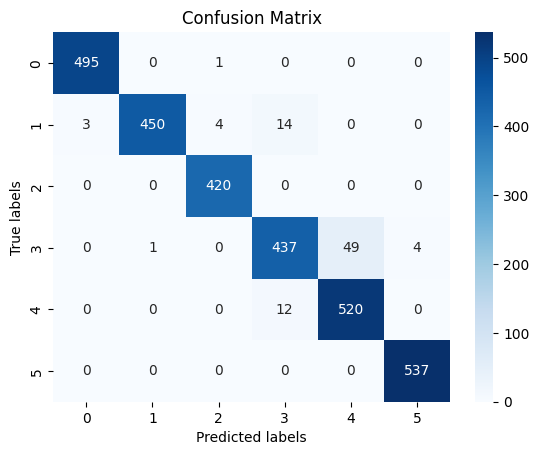

<Figure size 640x480 with 0 Axes>

In [ ]:
model.save('Adaptive_Multikernel_ResNetV2_BI-LSTM_Attention_extra.h5')

# model = load_model('/content/Adaptive_Multikernel_ResNetV2_BI-LSTM_Attention.h5', custom_objects={'AttentionLayer': AttentionLayer})

# model = tf.keras.models.load_model('/content/Adaptive_Multikernel_ResNetV2_BI-LSTM_Attention_extra.h5',
                                  #  custom_objects= {'SelfAttention':SelfAttention})
outs = model.predict(x_test)


class_names= np.unique(np.argmax(y_test,axis=1))


cm = confusion_matrix(np.argmax(y_test,axis=1), np.argmax(outs[0],axis=1))

print(classification_report(np.argmax(y_test,axis=1), np.argmax(outs[0],axis=1)))


sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=class_names, yticklabels=class_names)

# set the axis labels and title of the plot
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')

# show the plot
plt.show()
plt.savefig('confusion_matrix.png')
